In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("Domain_with_authors_and_tweet_ids.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30262 entries, 0 to 30261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Processed_Text  30262 non-null  object
 1   Emotion         30262 non-null  object
 2   Text            1 non-null      object
 3   Author          1 non-null      object
 4   Tweet_id        1 non-null      object
dtypes: object(5)
memory usage: 1.2+ MB


In [ ]:
df.head()

,Emotion,Text,Author,Tweet_id
0,sadness,i didnt feel humiliated,Author_0,724809917314357154
1,sadness,i can go from feeling so hopeless to so damned...,Author_1,406731490426134282
2,anger,im grabbing a minute to post i feel greedy wrong,Author_2,238673658469314976
3,love,i am ever feeling nostalgic about the fireplac...,Author_3,404820730155404793
4,anger,i am feeling grouchy,Author_4,505678135213353257


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
!pip install contractions

In [ ]:
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
import contractions

def expand_contractions(text):
    return contractions.fix(text)

def clean_content(text):
    text = expand_contractions(text)
    clean_text = re.sub(r'@\w+\s?', '', text)
    return clean_text

def lowercase_text(text):
    return text.lower()

def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

def remove_numbers(text):
    return ''.join([char for char in text if not char.isdigit()])

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

def remove_underscores(text):
    return text.replace("_", " ")


lemmatizer = WordNetLemmatizer()
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

df['Processed_Text'] = df['Text']
df['Processed_Text'] = df['Processed_Text'].apply(clean_content)
df['Processed_Text'] = df['Processed_Text'].apply(lowercase_text)
df['Processed_Text'] = df['Processed_Text'].apply(remove_punctuation)
df['Processed_Text'] = df['Processed_Text'].apply(remove_numbers)
df['Processed_Text'] = df['Processed_Text'].apply(remove_stopwords)
df['Processed_Text'] = df['Processed_Text'].apply(remove_urls)
df['Processed_Text'] = df['Processed_Text'].apply(remove_html_tags)
df['Processed_Text'] = df['Processed_Text'].apply(remove_underscores)
df['Processed_Text'] = df['Processed_Text'].apply(tokenize_and_lemmatize)

df = df.loc[df['Processed_Text'].apply(lambda x: len(x) >= 3)]

df.drop_duplicates(subset='Processed_Text', inplace=True)
df.reset_index(drop=True, inplace=True)

<ipython-input-15-a3fcee70c641>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset='Processed_Text', inplace=True)


In [ ]:
df[['Processed_Text', 'Emotion']].to_csv('Domain_Pre_Processed_Dataset.csv', index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30261 entries, 0 to 30260
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Emotion         30261 non-null  object
 1   Text            30261 non-null  object
 2   Author          30261 non-null  object
 3   Tweet_id        30261 non-null  int64 
 4   Processed_Text  30261 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [ ]:
MAX_LEN = 100
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df['Processed_Text'])
sequences = tokenizer.texts_to_sequences(df['Processed_Text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
VOCAB_SIZE = len(tokenizer.word_index) + 1

In [ ]:
VOCAB_SIZE

25614

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['Emotion'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [ ]:
model = tf.keras.Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))),
    Dropout(0.5),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))),
    Dropout(0.5),
    Dense(7, activation='softmax', kernel_regularizer=l2(0.001))
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.001)

In [ ]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=128, callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/5
166/166 [==============================] - ETA: 0s - loss: 1.9771 - accuracy: 0.2713
Epoch 1: val_loss improved from inf to 1.62276, saving model to best_model_lstm.h5
166/166 [==============================] - 37s 187ms/step - loss: 1.9771 - accuracy: 0.2713 - val_loss: 1.6228 - val_accuracy: 0.3638 - lr: 0.0010
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - ETA: 0s - loss: 1.4001 - accuracy: 0.4511
Epoch 2: val_loss improved from 1.62276 to 1.23761, saving model to best_model_lstm.h5
166/166 [==============================] - 30s 178ms/step - loss: 1.4001 - accuracy: 0.4511 - val_loss: 1.2376 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 3/5
166/166 [==============================] - ETA: 0s - loss: 1.0657 - accuracy: 0.6258
Epoch 3: val_loss improved from 1.23761 to 1.09551, saving model to best_model_lstm.h5
166/166 [==============================] - 29s 176ms/step - loss: 1.0657 - accuracy: 0.6258 - val_loss: 1.0955 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 4/5
166/166 [==============================] - ETA: 0s - loss: 0.7930 - accuracy: 0.7517
Epoch 4: val_loss improved from 1.09551 to 1.04127, saving model to best_model_lstm.h5
166/166 [==============================] - 29s 177ms/step - loss: 0.7930 - accuracy: 0.7517 - val_loss: 1.0413 - val_accuracy: 0.6662 - lr: 0.0010
Epoch 5/5
166/166 [====

In [ ]:
train_acc = history.history['accuracy']
last_epoch_train_acc = train_acc[-1]
print(f"Training accuracy after the last epoch: {last_epoch_train_acc*100:.2f}%")
val_acc = history.history['val_accuracy']
last_epoch_val_acc = val_acc[-1]
print(f"Validation accuracy after the last epoch: {last_epoch_val_acc*100:.2f}%")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")

Training accuracy after the last epoch: 82.83%
Validation accuracy after the last epoch: 68.37%
190/190 [==============================] - 5s 25ms/step - loss: 1.0031 - accuracy: 0.6864
Test accuracy: 68.64%


In [ ]:
!pip install seaborn

190/190 [==============================] - 6s 25ms/step


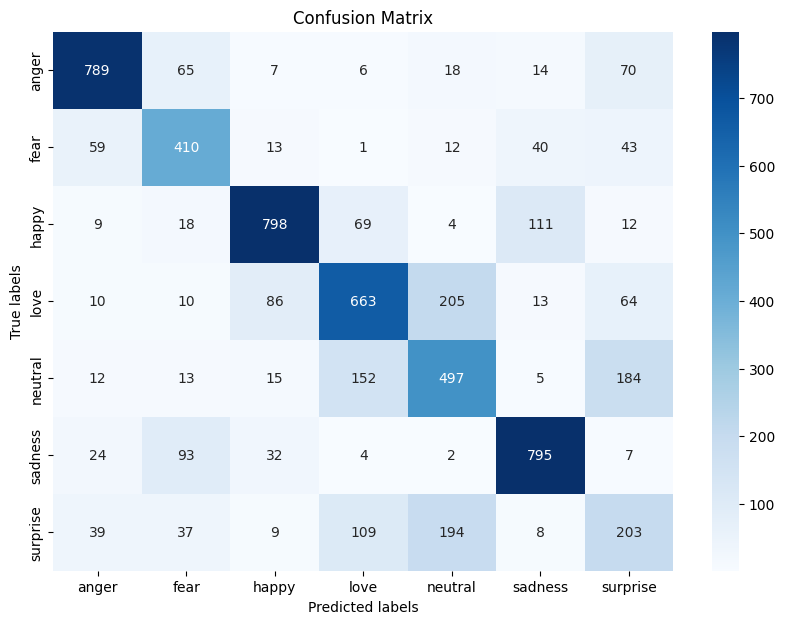

              precision    recall  f1-score   support

       anger       0.84      0.81      0.83       969
        fear       0.63      0.71      0.67       578
       happy       0.83      0.78      0.81      1021
        love       0.66      0.63      0.65      1051
     neutral       0.53      0.57      0.55       878
     sadness       0.81      0.83      0.82       957
    surprise       0.35      0.34      0.34       599

    accuracy                           0.69      6053
   macro avg       0.66      0.67      0.67      6053
weighted avg       0.69      0.69      0.69      6053



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print(report)

In [ ]:
from sklearn.utils import resample
def targeted_upsample(X, y, target_classes, max_size):
    X_resampled, y_resampled = list(X), list(y)
    for class_name in target_classes:
        class_index = label_encoder.transform([class_name])[0]
        X_class = X[y == class_index]
        y_class = y[y == class_index]

        X_class_resampled = resample(X_class, replace=True, n_samples=max_size, random_state=42)
        y_class_resampled = [class_index] * max_size

        X_resampled.extend(X_class_resampled)
        y_resampled.extend(y_class_resampled)

    return np.array(X_resampled), np.array(y_resampled)

target_classes = ['love', 'neutral', 'surprise']
max_size = 1000

X_resampled, y_resampled = targeted_upsample(padded_sequences, labels, target_classes, max_size)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.125, random_state=42)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.001)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=128, callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/5
228/228 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.8165
Epoch 1: val_loss improved from inf to 0.74714, saving model to best_model_lstm.h5
228/228 [==============================] - 47s 182ms/step - loss: 0.6708 - accuracy: 0.8165 - val_loss: 0.7471 - val_accuracy: 0.7775 - lr: 0.0010
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


228/228 [==============================] - ETA: 0s - loss: 0.5354 - accuracy: 0.8676
Epoch 2: val_loss improved from 0.74714 to 0.65900, saving model to best_model_lstm.h5
228/228 [==============================] - 40s 175ms/step - loss: 0.5354 - accuracy: 0.8676 - val_loss: 0.6590 - val_accuracy: 0.8059 - lr: 0.0010
Epoch 3/5
228/228 [==============================] - ETA: 0s - loss: 0.4322 - accuracy: 0.8990
Epoch 3: val_loss did not improve from 0.65900
228/228 [==============================] - 40s 173ms/step - loss: 0.4322 - accuracy: 0.8990 - val_loss: 0.6794 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 4/5
228/228 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.9142Restoring model weights from the end of the best epoch: 2.

Epoch 4: val_loss did not improve from 0.65900
228/228 [==============================] - 40s 174ms/step - loss: 0.3777 - accuracy: 0.9142 - val_loss: 0.6978 - val_accuracy: 0.8054 - lr: 0.0010
Epoch 4: early stopping


In [ ]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Training accuracy: {accuracy*100:.2f}%")

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {accuracy*100:.2f}%")

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}")

910/910 [==============================] - 23s 25ms/step - loss: 0.3726 - accuracy: 0.9143
Training accuracy: 91.43%
130/130 [==============================] - 3s 25ms/step - loss: 0.6590 - accuracy: 0.8059
Validation accuracy: 80.59%
208/208 [==============================] - 5s 26ms/step - loss: 0.5653 - accuracy: 0.8453
Test Accuracy: 84.53


208/208 [==============================] - 6s 25ms/step


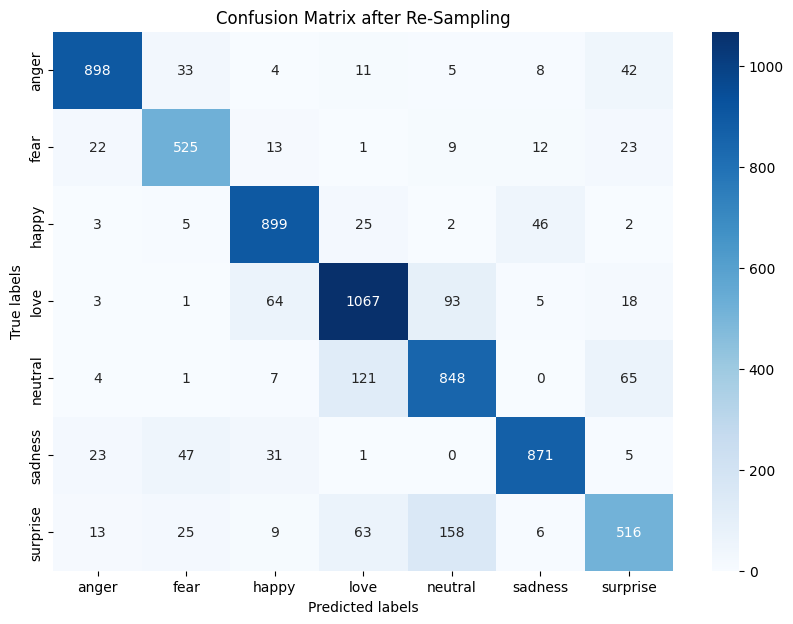

              precision    recall  f1-score   support

       anger       0.93      0.90      0.91      1001
        fear       0.82      0.87      0.85       605
       happy       0.88      0.92      0.89       982
        love       0.83      0.85      0.84      1251
     neutral       0.76      0.81      0.78      1046
     sadness       0.92      0.89      0.90       978
    surprise       0.77      0.65      0.71       790

    accuracy                           0.85      6653
   macro avg       0.84      0.84      0.84      6653
weighted avg       0.85      0.85      0.84      6653



In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix after Re-Sampling')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print(report)

In [ ]:
model.save("Text Domain Project Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("Text Domain Project Model.h5")

In [ ]:
def preprocess_text(text):
    text = clean_content(text)
    text = lowercase_text(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_stopwords(text)
    text = remove_urls(text)
    text = remove_html_tags(text)
    text = remove_underscores(text)
    text = tokenize_and_lemmatize(text)
    return text

In [ ]:
def text_to_padded_sequence(text):
    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
    return padded

In [ ]:
def predict_emotion(text, loaded_model):
    processed_text = preprocess_text(text)
    padded_sequence = text_to_padded_sequence(processed_text)
    prediction = model.predict(padded_sequence)
    predicted_label = label_encoder.inverse_transform([prediction.argmax()])[0]
    return predicted_label

In [ ]:
text = input("Enter the text you want to analyze: ")

predicted_emotion = predict_emotion(text,loaded_model)

print(f"\nThe predicted emotion for the given text is: {predicted_emotion}")

Enter the text you want to analyze: gautam gambhir is my inspiration
1/1 [==============================] - 0s 35ms/step

The predicted emotion for the given text is: love


In [ ]:
import pandas as pd
df = pd.read_csv("Domain_Pre_Processed_Dataset.csv")

while True:
    text = input("Enter the text you want to analyze (or type 'exit' to quit): ")

    if text.lower() == 'exit':
        print("Exiting...")
        break

    predicted_emotion = predict_emotion(text, loaded_model)

    new_row = {'Text': text, 'Emotion': predicted_emotion, 'Processed_Text': preprocess_text(text), 'Author': 'Random Author', 'Tweet_id': 'Random ID'}

    new_df = pd.DataFrame([new_row])

    df = pd.concat([df, new_df], ignore_index=True)

    print("\nPredicted Emotion:", predicted_emotion)
    print("Text:", text)
    print("Processed Text:", preprocess_text(text))
    print("Author:", "Random Author")
    print("Tweet ID:", "Random ID")

    df.to_csv('Domain_Pre_Processed_Dataset.csv', index=False)

print("Process finished.")


Enter the text you want to analyze (or type 'exit' to quit): gautam gambhir is my inspiration
1/1 [==============================] - 0s 33ms/step

Predicted Emotion: love
Text: gautam gambhir is my inspiration
Processed Text: gautam gambhir inspiration
Author: Random Author
Tweet ID: Random ID
Enter the text you want to analyze (or type 'exit' to quit): exit
Exiting...
Process finished.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30262 entries, 0 to 30261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Processed_Text  30262 non-null  object
 1   Emotion         30262 non-null  object
 2   Text            1 non-null      object
 3   Author          1 non-null      object
 4   Tweet_id        1 non-null      object
dtypes: object(5)
memory usage: 1.2+ MB
